# Example using Plotly

This is an example of using the Plotly library for interactive plots in jupyterlab. Ensure that your environment has plotly and jupyter-plotly-extension installed.

In [30]:
%matplotlib inline

Initialize orkit and bring up the python-java interface

In [31]:
import orekit_jpype
vm = orekit_jpype.initVM()

JVM already started, resuming on started JVM


Now set up the pointer to the orekit-data.zip file, using one of the helper files. The file should be in current directory if not specified otherwise.

In [32]:
from orekit_jpype.pyhelpers import setup_orekit_data, absolutedate_to_datetime
setup_orekit_data()

Now we are set up to import and use objects from the orekit library. Packages can be imported as they were native Python packages

In [33]:
from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import IERSConventions, Constants

from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from java.io import File

from math import radians, pi
import pandas as pd
import numpy as np


## Define orbit 

Perform simple TLE propagation, using two strings as input.

In [34]:
#SPOT-5 
tle_line1 = "1 27421U 02021A   02124.48976499 -.00021470  00000-0 -89879-2 0    20"
tle_line2 = "2 27421  98.7490 199.5121 0001333 133.9522 226.1918 14.26113993    62"

Create a TLE object

In [35]:
mytle = TLE(tle_line1,tle_line2)

In [36]:
mytle.getDate()

<AbsoluteDate: 2002-05-04T11:45:15.695136Z>

## Define planet Earth 

In [37]:
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)

Note that (as an option) the Python interface maps get/setXX() to direct parameters, which is more "Pythonic"

In [38]:
earth.getFlattening()

0.0033528106647474805

## Define a Station
Define a ground station to perform comparison with in our propagation

In [39]:
longitude = radians(21.063)
latitude  = radians(67.878)
altitude  = 341.0
station1 = GeodeticPoint(latitude, longitude, altitude)
sta1Frame = TopocentricFrame(earth, station1, "Esrange")

Sometimes it is nice to investigate object interactively outside cells. If using JupyterLab, open a New Console for the kernel and investigate sta1Frame. For example getPoint()

## Set up propagation 

In [40]:
initialDate = AbsoluteDate(DateComponents(2002, 5, 7),
                           TimeComponents.H00,
                           TimeScalesFactory.getUTC())

inertialFrame = FramesFactory.getEME2000()

propagator = TLEPropagator.selectExtrapolator(mytle)

A small loop that steps through the propagation and stores values in a python array

In [41]:
pvs = []
extrapDate = initialDate
finalDate = extrapDate.shiftedBy(60.0 * 60 * 24 * 3)  #seconds

while (extrapDate.compareTo(finalDate) <= 0.0):
    pv = propagator.getPVCoordinates(extrapDate, inertialFrame)
    pvs.append(pv)
    extrapDate = extrapDate.shiftedBy(20.0)


Take the results and populate a Pandas DataFrame with them for managing the results.

In [42]:
prop_data = pd.DataFrame(data=pvs, columns=['pv'])

prop_data['Position'] = prop_data['pv'].apply(lambda x: x.getPosition())
prop_data['datetime'] = prop_data['pv'].apply(lambda x: absolutedate_to_datetime(x.getDate()))
prop_data['elevation'] = prop_data['pv'].apply(lambda x: sta1Frame.getElevation(x.getPosition(), inertialFrame, x.getDate())*180.0/pi )
prop_data['azimuth'] = prop_data['pv'].apply(lambda x: sta1Frame.getAzimuth(x.getPosition(), inertialFrame, x.getDate())*180.0/pi )
prop_data.set_index('datetime', inplace=True, drop=False)
prop_data.index.name = 'Timestamp'

In [43]:
prop_data.head()

,pv,Position,datetime,elevation,azimuth
Timestamp,,,,,
2002-05-07 00:00:00,"{2002-05-07T00:00:00.000, P(-746330.6708309231...","{-746,330.6708309231; -1,463,626.226788035; -7...",2002-05-07 00:00:00,-71.287402,181.060576
2002-05-07 00:00:20,"{2002-05-07T00:00:20.000, P(-883435.556221901,...","{-883,435.556221901; -1,514,542.4907364103; -6...",2002-05-07 00:00:20,-70.825293,182.482355
2002-05-07 00:00:40,"{2002-05-07T00:00:40.000, P(-1020163.513606520...","{-1,020,163.5136065207; -1,564,812.561188889; ...",2002-05-07 00:00:40,-70.355643,183.850049
2002-05-07 00:01:00,"{2002-05-07T00:01:00.000, P(-1156456.184620767...","{-1,156,456.1846207676; -1,614,414.9561095175;...",2002-05-07 00:01:00,-69.878974,185.166756
2002-05-07 00:01:20,"{2002-05-07T00:01:20.000, P(-1292255.388093781...","{-1,292,255.3880937814; -1,663,328.4725072354;...",2002-05-07 00:01:20,-69.395767,186.435439


Let us add a bit more advanced data. First calculate the satellite subpoint geographical coordinates and store in the pandas DataFrame.

In [44]:
prop_data['groundpoint'] = prop_data['pv'].apply(lambda pv: earth.transform(pv.getPosition(), inertialFrame, pv.getDate()))
prop_data['latitude'] = np.degrees(prop_data.groundpoint.apply(lambda gp: gp.getLatitude()))
prop_data['longitude'] = np.degrees(prop_data.groundpoint.apply(lambda gp: gp.getLongitude()))
prop_data['day'] = prop_data.datetime.dt.dayofyear
prop_data['hour'] = prop_data.datetime.dt.hour

Make a separate vector for visibility

In [45]:
prop_data['visible'] = prop_data.elevation.apply(lambda el: 'Yes' if el>0 else 'No')

## Plot Results with Pandas

The following example is using the [Pandas]() package for plotting. Pandas uses matplotlib but with a reduced syntax and some additional polishing. The Pandas package has features for filtering in several steps.

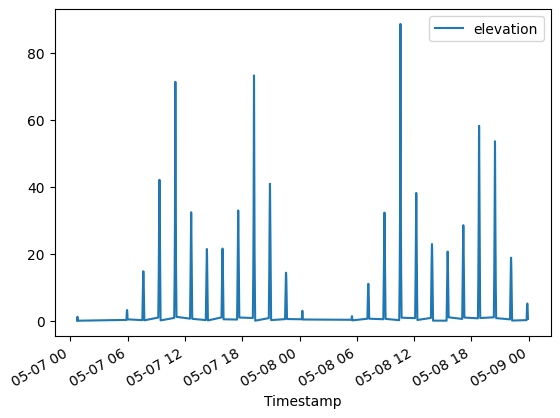

In [46]:
prop_data[prop_data.elevation>0]['2002-05-07':'2002-05-08'].plot(y='elevation');

# Plot results with Plotly 

However, these graphs are not interactive and several new libraries are being developed for more interactivity with data and plots. One in Plotly. Here we will use plotly-express for simple interactive plotting.

Plotly express that is used in these examples is a simplified front end, using a Pandas frame as data source.


In [47]:
import plotly.express as px

First plot the elevation as a function of time. Note that the plot has possibility to zoom and a hoover giving additional information about that point.

In [48]:
px.line(prop_data[prop_data.elevation>0], y='elevation', x='datetime', hover_name="datetime", 
        hover_data=['azimuth',
                    'elevation',
                    'latitude',
                    'longitude'])

## Map plot 

Plotly has possibilites to plot geographical data, and with the plotly express interface the scatter_geo gives a quick way to visualize data. Note that this is map visualization that does not take into account the altitude of the object.

In [49]:
px.scatter_geo(prop_data['2002-05-07':'2002-05-07'],
               animation_frame='hour',
               color='visible',
               lat='latitude',
               lon='longitude',
               opacity=0.3,
               hover_data=['elevation', 'azimuth'],
           projection='orthographic',)
